This notebook runs simple models on simple data:
* Features: demographics and summary statistics for vital signs, 1 patient/csn 1 row
* Models: logistic regression, random forest, gradient boosting machine, and simple MLP
* Train: 2016 - 2017, Validation: 2018, Test: 2019
* Evaluation: AUROC and PR

In [1]:
import sys, time, datetime
import numpy as np
import pandas as pd
from pandas import read_csv
import seaborn as sns
import matplotlib.pyplot as plt 

import tensorflow as tf
# tf.__version__

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.optimizers import Adam

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
#, plot_roc_curve, plot_precision_recall_curve

In [2]:
%load_ext rpy2.ipython
# to reload
# %reload_ext rpy2.ipython

In [3]:
%%R 
# -i df -w 5 -h 5 --units in -r 200
# the above line needs to be first in the cell, after comments
# import df from global environment
# make default figure size 5 by 5 inches with 200 dpi resolution

library(caret) # import this before glmnet to avoid rlang version problem
# library(xgboost)
library(data.table)
library(tidyverse)
library(lubridate)
library(Matrix)
# library(slam)
library(glmnet)
library(bit64)
# library(mtools) for one hot coder, not available on Nero or use caret or tidyr
library(mice)
library(pROC)

R[write to console]: Loading required package: lattice

R[write to console]: Loading required package: ggplot2

R[write to console]: data.table 1.12.8 using 16 threads (see ?getDTthreads).  Latest news: r-datatable.com

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

R[write to console]: ✔ tibble  3.0.3     ✔ dplyr   1.0.0
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0
✔ purrr   0.3.4     

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::lift()      masks caret::lift()
✖ purrr::transpose() masks data.table::transpose()

R[write to console]: 
Attaching package: ‘lubridate’


R[write to console]: The following objects are mask

In [13]:
# %R -o df1 -o df
# %R -i cohort

In [4]:
%%R 
df_vs <- read.csv("./Data/data_simple.csv")
print(dim(df_vs))
print(colnames(df_vs))

[1] 41654   108
  [1] "anon_id"                      "pat_enc_csn_id_coded"        
  [3] "inpatient_data_id_coded"      "label_max24"                 
  [5] "admit_time"                   "admit_label"                 
  [7] "label_24hr_recent"            "label_12hr_recent"           
  [9] "has_admit_label"              "first_label"                 
 [11] "first_label_time_since_admit" "acute_to_critical_label"     
 [13] "critical_to_acute_label"      "DBP_count"                   
 [15] "DBP_first_val"                "DBP_fldiff"                  
 [17] "DBP_IQRx"                     "DBP_last_val"                
 [19] "DBP_madx"                     "DBP_maxx"                    
 [21] "DBP_meanx"                    "DBP_medianx"                 
 [23] "DBP_minx"                     "DBP_mmdiff"                  
 [25] "DBP_sdx"                      "Pulse_count"                 
 [27] "Pulse_first_val"              "Pulse_fldiff"                
 [29] "Pulse_IQRx"              

In [5]:
%%R
df_vstrain <- df_vs %>% filter(year(admit_time) %in% c(2015, 2016, 2017))
df_vsval <- df_vs %>% filter(year(admit_time) == 2018)
df_vstest <- df_vs %>% filter(year(admit_time) == 2019)


# df_vstrain <- df_vs %>% filter(ymd_hms(admit_time) < as.Date("2018-01-01"))
# df_vsval <- df_vs %>% filter(ymd_hms(admit_time) >= as.Date("2018-01-01") & 
#                                 ymd_hms(admit_time) <= as.Date("2018-12-31"))
# df_vstest <- df_vs %>% filter(ymd_hms(admit_time) > as.Date("2019-01-01") & 
#                                 ymd_hms(admit_time) <= as.Date("2019-12-31"))

In [6]:
%%R
print(nrow(df_vstrain)) #22037
print(nrow(df_vsval)) #9521
print(nrow(df_vstest)) #10096
# colnames(df_vstrain)

[1] 22037
[1] 9521
[1] 10096


### Python codes for modeling

In [7]:
df = read_csv("./Data/data_simple.csv")
print(df.label_24hr_recent.value_counts())

0    37762
1     3892
Name: label_24hr_recent, dtype: int64


In [11]:
# cohort.pat_enc_csn_id_coded.value_counts()
print(df.pat_enc_csn_id_coded.nunique())
print(df[(df['admit_time'] >= '2019-01-01') & (df['admit_time'] <= '2019-12-31')].pat_enc_csn_id_coded.nunique())
print(df[(df['admit_time'] > '2018-12-31') & (df['admit_time'] <= '2019-12-31')].pat_enc_csn_id_coded.nunique())
print(df[(df['admit_time'] > '2018-12-31') & (df['admit_time'] <= '2019-12-31')].pat_enc_csn_id_coded.nunique())

# below is ok, consistent with the years
print(df[(df['admit_time'] >= '2019-01-01') & (df['admit_time'] <= '2020-01-01')].pat_enc_csn_id_coded.nunique())
print(df[(df['admit_time'] >= '2018-01-01') & (df['admit_time'] <= '2019-01-01')].pat_enc_csn_id_coded.nunique())
print(df[(df['admit_time'] >= '2015-01-01') & (df['admit_time'] <= '2018-01-01')].pat_enc_csn_id_coded.nunique())

41654
10077
10103
10103
10096
9521
22037


In [12]:
# print(df.dtypes)
print(type(df['admit_time']))
df["admit_time"] = pd.to_datetime(df["admit_time"])
print(type(df['admit_time']))
years = df['admit_time'].dt.year

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [39]:
# all demographics and vital signs summary stats
df_train =  df[(df['admit_time'].dt.year < 2018)]
df_val =  df[(df['admit_time'].dt.year == 2018)]
df_test =  df[(df['admit_time'].dt.year == 2019)]
              
df.pat_enc_csn_id_coded.nunique()

41654

In [34]:
# note that the first set of VS is repeated in demos
print(df_test.shape)
print(df_train.shape)
print(df_val.shape)
print(df.shape)
print(list(df_test.columns))

(10096, 108)
(22037, 108)
(9521, 108)
(41654, 108)
['anon_id', 'pat_enc_csn_id_coded', 'inpatient_data_id_coded', 'label_max24', 'admit_time', 'admit_label', 'label_24hr_recent', 'label_12hr_recent', 'has_admit_label', 'first_label', 'first_label_time_since_admit', 'acute_to_critical_label', 'critical_to_acute_label', 'DBP_count', 'DBP_first_val', 'DBP_fldiff', 'DBP_IQRx', 'DBP_last_val', 'DBP_madx', 'DBP_maxx', 'DBP_meanx', 'DBP_medianx', 'DBP_minx', 'DBP_mmdiff', 'DBP_sdx', 'Pulse_count', 'Pulse_first_val', 'Pulse_fldiff', 'Pulse_IQRx', 'Pulse_last_val', 'Pulse_madx', 'Pulse_maxx', 'Pulse_meanx', 'Pulse_medianx', 'Pulse_minx', 'Pulse_mmdiff', 'Pulse_sdx', 'RR_count', 'RR_first_val', 'RR_fldiff', 'RR_IQRx', 'RR_last_val', 'RR_madx', 'RR_maxx', 'RR_meanx', 'RR_medianx', 'RR_minx', 'RR_mmdiff', 'RR_sdx', 'SBP_count', 'SBP_first_val', 'SBP_fldiff', 'SBP_IQRx', 'SBP_last_val', 'SBP_madx', 'SBP_maxx', 'SBP_meanx', 'SBP_medianx', 'SBP_minx', 'SBP_mmdiff', 'SBP_sdx', 'SpO2_count', 'SpO2_firs

In [40]:
# only demographics and first values of vital signs
first_vals = [col for col in df.columns if 'first_val' in col]
demos = ['ESI_i', 'delta_ESI', 'gender', 'age', 'medis', 'English', 
         'Height_i', 'delta_H', 'Weight_i', 'delta_W', 
#          'SBP', 'DBP', 'Pulse', 'RR', 'SpO2', 'Temp', # these are first_val
         'race.Asian', 'race.Black', 'race.Native.American', 'race.Other', 
         'race.Pacific.Islander', 'race.Unknown', 'race.White']
features = demos  + first_vals
print(first_vals)
print(features)
print(len(features))

['DBP_first_val', 'Pulse_first_val', 'RR_first_val', 'SBP_first_val', 'SpO2_first_val', 'Temp_first_val']
['ESI_i', 'delta_ESI', 'gender', 'age', 'medis', 'English', 'Height_i', 'delta_H', 'Weight_i', 'delta_W', 'race.Asian', 'race.Black', 'race.Native.American', 'race.Other', 'race.Pacific.Islander', 'race.Unknown', 'race.White', 'DBP_first_val', 'Pulse_first_val', 'RR_first_val', 'SBP_first_val', 'SpO2_first_val', 'Temp_first_val']
23


In [36]:
# save IDs and labels:
test_IDs = ['anon_id', 'pat_enc_csn_id_coded', 'label_24hr_recent']
df_testIDs = df_test[test_IDs]
print(df_testIDs)

         anon_id  pat_enc_csn_id_coded  label_24hr_recent
0      JC29f8ad2          131274729058                  0
1      JC29f8ad3          131278291027                  0
2      JC29f8b9c          131266787806                  0
3      JC29f8beb          131264387263                  0
4      JC29f8beb          131279241689                  0
...          ...                   ...                ...
41626   JCec4575          131261383508                  0
41633   JCec466f          131268389874                  0
41643   JCec4722          131268321543                  0
41644   JCec4785          131279578912                  0
41651   JCec4853          131273484812                  0

[10096 rows x 3 columns]


In [41]:
drops = ['anon_id', 'pat_enc_csn_id_coded', 'inpatient_data_id_coded', 'label_max24', 'admit_time', 'admit_label', 
          'label_12hr_recent', 'has_admit_label', 'first_label', 'first_label_time_since_admit', 
          'acute_to_critical_label', 'critical_to_acute_label',
          'SBP', 'DBP', 'Pulse', 'RR', 'SpO2', 'Temp']
# ['jc_uid', 'pat_enc_csn_id_coded', 'admit_time']
df_train = df_train.drop(drops, axis=1)
df_val = df_val.drop(drops, axis=1)
df_test = df_test.drop(columns=drops)

print(list(df_test.columns))
print(df_test.dtypes)

['label_24hr_recent', 'DBP_count', 'DBP_first_val', 'DBP_fldiff', 'DBP_IQRx', 'DBP_last_val', 'DBP_madx', 'DBP_maxx', 'DBP_meanx', 'DBP_medianx', 'DBP_minx', 'DBP_mmdiff', 'DBP_sdx', 'Pulse_count', 'Pulse_first_val', 'Pulse_fldiff', 'Pulse_IQRx', 'Pulse_last_val', 'Pulse_madx', 'Pulse_maxx', 'Pulse_meanx', 'Pulse_medianx', 'Pulse_minx', 'Pulse_mmdiff', 'Pulse_sdx', 'RR_count', 'RR_first_val', 'RR_fldiff', 'RR_IQRx', 'RR_last_val', 'RR_madx', 'RR_maxx', 'RR_meanx', 'RR_medianx', 'RR_minx', 'RR_mmdiff', 'RR_sdx', 'SBP_count', 'SBP_first_val', 'SBP_fldiff', 'SBP_IQRx', 'SBP_last_val', 'SBP_madx', 'SBP_maxx', 'SBP_meanx', 'SBP_medianx', 'SBP_minx', 'SBP_mmdiff', 'SBP_sdx', 'SpO2_count', 'SpO2_first_val', 'SpO2_fldiff', 'SpO2_IQRx', 'SpO2_last_val', 'SpO2_madx', 'SpO2_maxx', 'SpO2_meanx', 'SpO2_medianx', 'SpO2_minx', 'SpO2_mmdiff', 'SpO2_sdx', 'Temp_count', 'Temp_first_val', 'Temp_fldiff', 'Temp_IQRx', 'Temp_last_val', 'Temp_madx', 'Temp_maxx', 'Temp_meanx', 'Temp_medianx', 'Temp_minx', 'Te

In [46]:
# for only demographic and first vs values only
X_train = df_train[features].values
X_val = df_val[features].values
X_test = df_test[features].values

# choose the labels: level of care at 24hr mark
label = 'label_24hr_recent'
y_train = df_train[label].values
y_val = df_val[label].values
y_test = df_test[label].values

In [47]:
# check demo + 1st vs = 23 features
X_train.shape

(22037, 23)

In [48]:
# all demographic + first values ++ the rest of simple data (summary stats of VS)
X_train = df_train.values[:,1:]
y_train = df_train.values[:,0]

X_val = df_val.values[:,1:]
y_val = df_val.values[:,0]

X_test = df_test.values[:,1:]
y_test = df_test.values[:,0] 

In [49]:
# check all 89 features
X_train.shape

(22037, 89)

### Training

In [79]:
# Classification models for comparison, using defaults
def simple_modeling(X_train, y_train, X_test, y_test):
    models = [LogisticRegression(), # use l2 = Ridge as the default, ok since small number of predictors
              RandomForestClassifier(random_state = 1),
              GradientBoostingClassifier()] # loss = "deviance" as the default, lr=0.1, and criterio = fmse

    results = {}
    for model in models:
        model_name = str(model).split("(")[0]
        clf_model = model
        clf_model.fit(X_train, y_train)
        y_preds = clf_model.predict_proba(X_test)[:,1] # positive outcomes only
        
        # roc 
        auroc = round(roc_auc_score(y_test, y_preds), 3)
        print("AUROC = ", auroc)
        fpr, tpr, auc_thresholds = roc_curve(y_test, y_preds)
        
        # precision/recall
        avg_precision = round(average_precision_score(y_test, y_preds), 3)
        print("PR = ", avg_precision)
        precision, recall, pr_thresholds = precision_recall_curve(y_test, y_preds)

#         make_auc_prc_plots(clf_model, model_name, X_test, y_test)

#         roc_curve = plot_roc_curve(clf_model, X_test, y_test)
#         pr_curve = plot_precision_recall_curve(clf_model, X_test, y_test)

        results[model_name] = [auroc, avg_precision, 
                               fpr, tpr, auc_thresholds, 
                               precision, recall, pr_thresholds, y_preds]
        print("#" + model_name + " done")
        
    return(results)

In [80]:
# for only demographic and first vs values only
X_train = df_train[features].values
X_val = df_val[features].values
X_test = df_test[features].values

label = 'label_24hr_recent'
y_train = df_train[label].values
y_val = df_val[label].values
y_test = df_test[label].values

print(X_train.shape)

(22037, 23)


In [81]:
# first values, val and test
print("Results for val set: ")
results_val1 = simple_modeling(X_train, y_train, X_val, y_val)

print("Results for test set: ")
results_test1 = simple_modeling(X_train, y_train, X_test, y_test)

Results for val set: 


/share/sw/open/anaconda/3.next/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


AUROC =  0.74
PR =  0.264
#LogisticRegression done
AUROC =  0.761
PR =  0.312
#RandomForestClassifier done
AUROC =  0.781
PR =  0.341
#GradientBoostingClassifier done
Results for test set: 


/share/sw/open/anaconda/3.next/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


AUROC =  0.716
PR =  0.273
#LogisticRegression done
AUROC =  0.73
PR =  0.308
#RandomForestClassifier done
AUROC =  0.741
PR =  0.316
#GradientBoostingClassifier done


In [83]:
# ALL demographic + first values ++ the rest of simple data (summary stats of VS)
X_train = df_train.values[:,1:]
y_train = df_train.values[:,0]

X_val = df_val.values[:,1:]
y_val = df_val.values[:,0]

X_test = df_test.values[:,1:]
y_test = df_test.values[:,0] 

print(X_train.shape)

(22037, 89)


In [84]:
# ALL, validation and TEST set
print("Results for val set: ")
results_val = simple_modeling(X_train, y_train, X_val, y_val)

print("Results for test set: ")
results_test = simple_modeling(X_train, y_train, X_test, y_test)

Results for val set: 


/share/sw/open/anaconda/3.next/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


AUROC =  0.774
PR =  0.348
#LogisticRegression done
AUROC =  0.798
PR =  0.379
#RandomForestClassifier done
AUROC =  0.824
PR =  0.412
#GradientBoostingClassifier done
Results for test set: 


/share/sw/open/anaconda/3.next/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


AUROC =  0.786
PR =  0.345
#LogisticRegression done
AUROC =  0.784
PR =  0.379
#RandomForestClassifier done
AUROC =  0.809
PR =  0.41
#GradientBoostingClassifier done


### Simple MLP model

In [55]:
def create_mlp(dim):
    model = Sequential()
    model.add(Dense(32, input_dim=dim, activation="relu"))
    model.add(Dropout(.3))
    model.add(Dense(8, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    return model

In [56]:
# for only demographic and first vs values only
X_train = df_train[features].values
X_val = df_val[features].values
X_test = df_test[features].values

label = 'label_24hr_recent'
y_train = df_train[label].values
y_val = df_val[label].values
y_test = df_test[label].values

print(X_train.shape)

(22037, 23)


In [57]:
# check which shape (which data set, different number of features) and which batch size
b = 64
model1 = create_mlp(X_train.shape[1])
model1.compile(loss="binary_crossentropy", optimizer=Adam(lr=1e-3), metrics=['accuracy'])
history1 = model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=b)

print("outputs on val:")
predictions1 = model1.predict(X_val)
predictionsTrain1 = model1.predict(X_train)
mlp_results1 = model1.evaluate(X_val, y_val) 
print('test loss, test acc:', mlp_results1) 

# AUC and PR
y_preds_mlp1 = model1.predict(X_val).ravel()
fpr_mlp1, tpr_mlp1, thresholds_mlp1 = roc_curve(y_val, y_preds_mlp1)
prec_mlp1, recall_mlp1, pr_thresholds_mlp1 = precision_recall_curve(y_val, y_preds_mlp1)
print(round(roc_auc_score(y_val, y_preds_mlp1), 3))
print(round(average_precision_score(y_val, y_preds_mlp1), 3))

Epoch 1/20
345/345 [==============================] - 1s 2ms/step - loss: 0.7717 - accuracy: 0.8668 - val_loss: 0.3292 - val_accuracy: 0.9051
Epoch 2/20
345/345 [==============================] - 0s 1ms/step - loss: 0.3496 - accuracy: 0.9053 - val_loss: 0.3079 - val_accuracy: 0.9060
Epoch 3/20
345/345 [==============================] - 0s 1ms/step - loss: 0.3216 - accuracy: 0.9102 - val_loss: 0.3132 - val_accuracy: 0.9060
Epoch 4/20
345/345 [==============================] - 0s 1ms/step - loss: 0.3092 - accuracy: 0.9106 - val_loss: 0.3116 - val_accuracy: 0.9060
Epoch 5/20
345/345 [==============================] - 0s 1ms/step - loss: 0.3035 - accuracy: 0.9105 - val_loss: 0.3012 - val_accuracy: 0.9061
Epoch 6/20
345/345 [==============================] - 0s 1ms/step - loss: 0.3002 - accuracy: 0.9102 - val_loss: 0.3011 - val_accuracy: 0.9063
Epoch 7/20
345/345 [==============================] - 0s 1ms/step - loss: 0.2963 - accuracy: 0.9101 - val_loss: 0.3130 - val_accuracy: 0.9065
Epoch 

In [58]:
# ALL demographic + first values ++ the rest of simple data (summary stats of VS)
X_train = df_train.values[:,1:]
y_train = df_train.values[:,0]

X_val = df_val.values[:,1:]
y_val = df_val.values[:,0]

X_test = df_test.values[:,1:]
y_test = df_test.values[:,0] 

print(X_train.shape)

(22037, 89)


In [59]:
# check which shape (which data set, different number of features) and which batch size
b = 64
model = create_mlp(X_train.shape[1])
model.compile(loss="binary_crossentropy", optimizer=Adam(lr=1e-3), metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=b)

print("outputs on val:")
predictions = model.predict(X_val)
predictionsTrain = model.predict(X_train)
mlp_results = model.evaluate(X_val, y_val) 
print('test loss, test acc:', mlp_results) # batch size=64

# AUC and PR
y_preds_mlp = model.predict(X_val).ravel()
fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(y_val, y_preds_mlp)
prec_mlp, recall_mlp, pr_thresholds_mlp = precision_recall_curve(y_val, y_preds_mlp)
print(round(roc_auc_score(y_val, y_preds_mlp), 3))
print(round(average_precision_score(y_val, y_preds_mlp), 3))

Epoch 1/20
345/345 [==============================] - 1s 1ms/step - loss: 0.9813 - accuracy: 0.8822 - val_loss: 0.3104 - val_accuracy: 0.9061
Epoch 2/20
345/345 [==============================] - 0s 1ms/step - loss: 0.3164 - accuracy: 0.9070 - val_loss: 0.3065 - val_accuracy: 0.9061
Epoch 3/20
345/345 [==============================] - 0s 1ms/step - loss: 0.2942 - accuracy: 0.9101 - val_loss: 0.2922 - val_accuracy: 0.9064
Epoch 4/20
345/345 [==============================] - 0s 1ms/step - loss: 0.2834 - accuracy: 0.9102 - val_loss: 0.2801 - val_accuracy: 0.9066
Epoch 5/20
345/345 [==============================] - 0s 1ms/step - loss: 0.2764 - accuracy: 0.9116 - val_loss: 0.2744 - val_accuracy: 0.9085
Epoch 6/20
345/345 [==============================] - 0s 1ms/step - loss: 0.2747 - accuracy: 0.9109 - val_loss: 0.2788 - val_accuracy: 0.9066
Epoch 7/20
345/345 [==============================] - 0s 1ms/step - loss: 0.2683 - accuracy: 0.9121 - val_loss: 0.2814 - val_accuracy: 0.9088
Epoch 

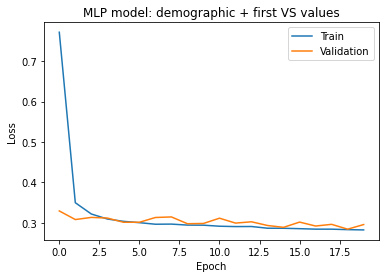

In [60]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.rcParams["figure.figsize"] = (4,4)
plt.title('MLP model: demographic + first VS values')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig("./Outputs/MLP_loss1.pdf")
plt.show()

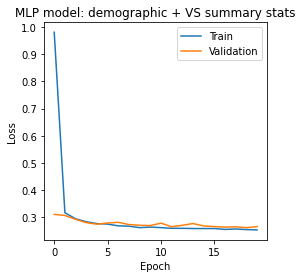

In [61]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.rcParams["figure.figsize"] = (4,4)
plt.title('MLP model: demographic + VS summary stats')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig("./Outputs/MLP_loss.pdf")
plt.show()

### Plots

In [62]:
# FIRST values + demo
# ---OLD
# Logistics
AUROC_log = 0.62
PR_log = 0.22
# RF
AUROC_rf = 0.70
PR2_rf = 0.30
# GBM
AUROC_gbm = 0.72
PR_gbm = 0.34
# MLP
AUROC_mlp = 0.66
PR4_mlp = 0.25

# ---NEW
AUROC_log =  0.716
PR_log =  0.273
#LogisticRegression done
AUROC_rf =  0.73
PR_rf =  0.308
#RandomForestClassifier done
AUROC_gbm =  0.741
PR_gbm =  0.316
#GradientBoostingClassifier done

AUROC_mlp=0.723
PR4_mlp=0.251

In [63]:
# FIRST
fpr1, tpr1, auc_thresholds1, precision1, recall1, pr_thresholds1, y_preds1 = results_test1["LogisticRegression"][2:9]
fpr2, tpr2, auc_thresholds2, precision2, recall2, pr_thresholds2, y_preds2 = results_test1["RandomForestClassifier"][2:9]
fpr3, tpr3, auc_thresholds3, precision3, recall3, pr_thresholds3, y_preds3 = results_test1["GradientBoostingClassifier"][2:9]

In [64]:
## ALL
# --OLD
# Logistics
AUROC_log = 0.78
PR_log =  0.38
# Random Forest
AUROC_rf =  0.80
PR_rf =  0.42
# Gradient Boosting
AUROC_gbm =  0.81
PR_gbm =  0.47
# MLP neural networks
AUROC_mlp = 0.78
PR_mlp = 0.37

# -- NEW
AUROC_log =  0.786
PR_log =  0.345
AUROC_rf =  0.784
PR_rf =  0.379
AUROC_gbm =  0.809
PR_gbm =  0.41
AUROC_mlp = 0.783
PR_mlp = 0.347

In [85]:
# ALL results from TEST
fpr1, tpr1, auc_thresholds1, precision1, recall1, pr_thresholds1, y_preds1a = results_test["LogisticRegression"][2:9]
fpr2, tpr2, auc_thresholds2, precision2, recall2, pr_thresholds2, y_preds2a = results_test["RandomForestClassifier"][2:9]
fpr3, tpr3, auc_thresholds3, precision3, recall3, pr_thresholds3, y_preds3a = results_test["GradientBoostingClassifier"][2:9]

No handles with labels found to put in legend.


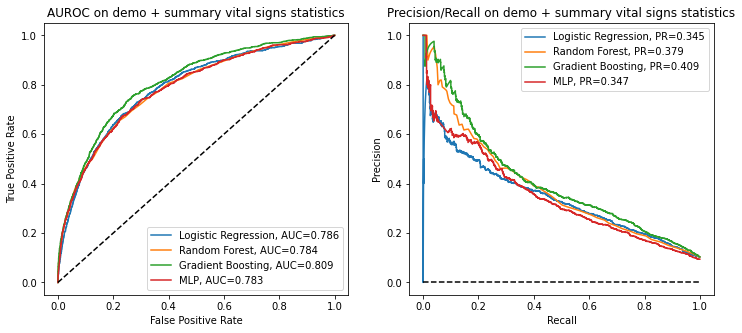

In [86]:
# Plot all ROC curves, average = macro for all models on TEST results
# plt.figure(1)
# plt.figure(0).clf()
fig, axs = plt.subplots(1, 2, figsize=(12,5))
axs[0].plot(fpr1,tpr1,label="Logistic Regression, AUC="+str(AUROC_log))
axs[0].plot(fpr2,tpr2,label="Random Forest, AUC="+str(AUROC_rf))
axs[0].plot(fpr3,tpr3,label="Gradient Boosting, AUC="+str(AUROC_gbm))
axs[0].plot(fpr_mlp,tpr_mlp,label="MLP, AUC="+str(AUROC_mlp))

plt.legend(loc=0)
axs[0].plot([0,1],[0,1], 'k--')

axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
# axs[0].set_title('AUROC on demo + first vital signs values') 
axs[0].set_title('AUROC on demo + summary vital signs statistics')  
axs[0].legend(loc="lower right")
# ax.legend((l2, l4), ('Logistic', 'Random'), loc='upper right')

axs[1].plot(recall1, precision1, label="Logistic Regression, PR="+str(PR_log))
axs[1].plot(recall2, precision2, label="Random Forest, PR="+str(PR_rf))
axs[1].plot(recall3, precision3, label="Gradient Boosting, PR="+str(PR_gbm))
axs[1].plot(recall_mlp, prec_mlp, label="MLP, PR="+str(PR_mlp))

axs[1].legend(loc=0)
axs[1].plot([0,1],[0,0], 'k--')

axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
# axs[1].set_title('Precision/Recall on demo + first vital signs values')
axs[1].set_title('Precision/Recall on demo + summary vital signs statistics')
axs[1].legend(loc="upper right")

# plt.savefig('./data/AUC_PRC_1_val.png')
plt.savefig('./Outputs/AUC_PRC_allsum.png')

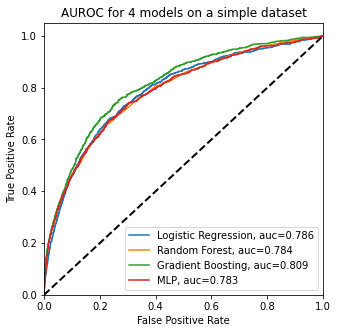

In [87]:
fig, ax = plt.subplots(figsize=(5,5))

plt.plot(fpr1,tpr1,label="Logistic Regression, auc="+str(AUROC_log))
plt.plot(fpr2,tpr2,label="Random Forest, auc="+str(AUROC_rf))
plt.plot(fpr3,tpr3,label="Gradient Boosting, auc="+str(AUROC_gbm))
plt.plot(fpr_mlp,tpr_mlp,label="MLP, auc="+str(AUROC_mlp))

plt.legend(loc=0)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUROC for 4 models on a simple dataset')
plt.legend(loc="lower right")
plt.show()

# plt.plot(recall1, precision1, label="Logistic Regression, pr="+str(PR1))
# plt.plot(recall2, precision2, label="Random Forest, pr="+str(PR2))
# plt.plot(recall3, precision3, label="Gradient Boosting, pr="+str(PR3))
# plt.plot(recall_mlp, prec_mlp, label="MLP, pr="+str(PR4))

# plt.legend(loc=0)

# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Precision/Recall for 3 models on a simple dataset')
# plt.legend(loc="upper right")
# plt.show()

In [207]:
# for only demographic and first vs values only
X_train = df_train[features].values
X_val = df_val[features].values
X_test = df_test[features].values

label = 'label_24hr_recent'
y_train = df_train[label].values
y_val = df_val[label].values
y_test = df_test[label].values

print(X_train.shape)

(22037, 29)


In [262]:
# first values, BYPASS this
gbm = GradientBoostingClassifier()
gbm.fit(X_train, y_train)
y_predsgbm1 = gbm.predict_proba(X_test)[:,1] # positive outcomes only
auroc_gbm = roc_auc_score(y_test, y_predsgbm1)
print("AUROC = ", auroc_gbm)
fpr_gbm, tpr_gbm, auc_thresholds_gbm = roc_curve(y_test, y_predsgbm1)
        
# precision/recall
avg_precision_gbm = average_precision_score(y_test, y_predsgbm1)
print("PR = ", avg_precision_gbm)
precision_gbm, recall_gbm, pr_thresholds_gbm = precision_recall_curve(y_test, y_predsgbm1)

# AUROC = 0.6965141866178887
# PR =  0.31266911068053527

AUROC =  0.7408341970216858
PR =  0.31558401630089444


No handles with labels found to put in legend.


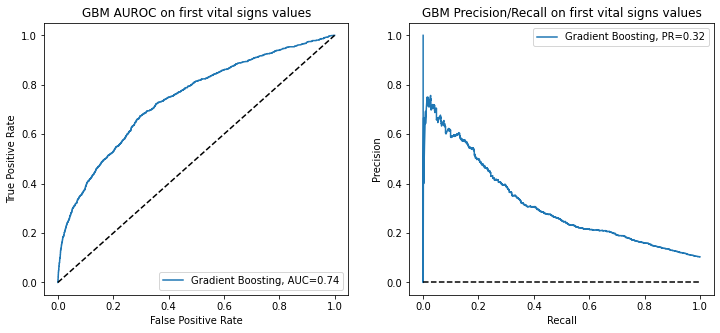

In [264]:
# fist values, BYPASS this
fig, axs = plt.subplots(1, 2, figsize=(12,5))
axs[0].plot(fpr_gbm,tpr_gbm,label="Gradient Boosting, AUC="+str(round(auroc_gbm,2)))

plt.legend(loc=0)
axs[0].plot([0,1],[0,1], 'k--')

axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].set_title('GBM AUROC on first vital signs values')  
axs[0].legend(loc="lower right")
# ax.legend((l2, l4), ('Logistic', 'Random'), loc='upper right')

axs[1].plot(recall_gbm, precision_gbm, label="Gradient Boosting, PR="+str(round(avg_precision_gbm,2)))

axs[1].legend(loc=0)
axs[1].plot([0,1],[0,0], 'k--')

axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')

axs[1].set_title('GBM Precision/Recall on first vital signs values')
# axs[1].set_title('GBM Precision/Recall on a simple dataset')
axs[1].legend(loc="upper right")

plt.savefig('./Outputs/AUC_PRC 1val_GBM.png')

In [77]:
# ALL demographic + first values ++ the rest of simple data (summary stats of VS)
X_train = df_train.values[:,1:]
y_train = df_train.values[:,0]

X_val = df_val.values[:,1:]
y_val = df_val.values[:,0]

X_test = df_test.values[:,1:]
y_test = df_test.values[:,0] 

print(X_train.shape)

(22037, 89)


No handles with labels found to put in legend.


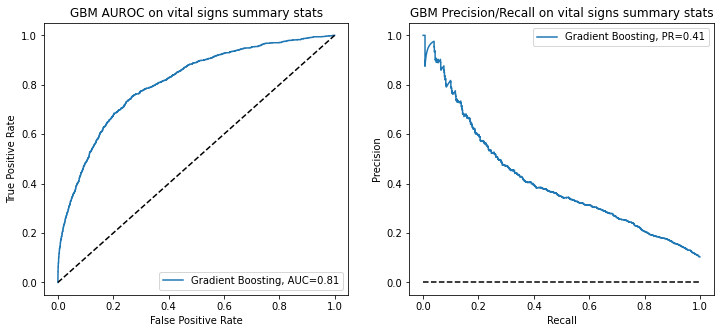

In [90]:
# ALL

auroc_gbm = results_test["GradientBoostingClassifier"][0:1][0]
avg_precision_gbm = results_test["GradientBoostingClassifier"][1:2][0]

fig, axs = plt.subplots(1, 2, figsize=(12,5))
axs[0].plot(fpr3,tpr3,label="Gradient Boosting, AUC="+str(round(auroc_gbm,2)))

plt.legend(loc=0)
axs[0].plot([0,1],[0,1], 'k--')

axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].set_title('GBM AUROC on vital signs summary stats')  
axs[0].legend(loc="lower right")
# ax.legend((l2, l4), ('Logistic', 'Random'), loc='upper right')

axs[1].plot(recall3, precision3, label="Gradient Boosting, PR="+str(round(avg_precision_gbm,2)))

axs[1].legend(loc=0)
axs[1].plot([0,1],[0,0], 'k--')

axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[1].set_title('GBM Precision/Recall on vital signs summary stats')
axs[1].legend(loc="upper right")

plt.savefig('./Outputs/AUC_PRC summarystats_GBM.png')

### Get the predicted values from the function results

In [92]:
# results from VALIDATION
y_predsgbm_val1 = results_val1["GradientBoostingClassifier"][8:9][0]
y_predsgbm_val = results_val["GradientBoostingClassifier"][8:9][0]

In [93]:
# results from TEST
y_predsgbm1 = results_test1["GradientBoostingClassifier"][8:9][0]
y_predsgbm = results_test["GradientBoostingClassifier"][8:9][0]
print(y_predsgbm1)
print(y_predsgbm)

[0.03884314 0.05225285 0.35552887 ... 0.04214298 0.04650365 0.19223755]
[0.08100122 0.03387201 0.07624271 ... 0.03754247 0.02691848 0.08100212]


In [94]:
# save the results from validation:
val_gbm_preds = pd.DataFrame({"y_val": y_val, "y_preds_vgbm1":y_predsgbm_val1, "y_preds_vgbm":y_predsgbm_val})
val_gbm_preds.to_csv(r'./Outputs/val_gbm_preds.csv', index = False)

In [95]:
val_gbm_preds.head()

,y_val,y_preds_vgbm1,y_preds_vgbm
0,0.0,0.070454,0.131454
1,1.0,0.209339,0.320747
2,0.0,0.026307,0.018903
3,0.0,0.046673,0.031796
4,0.0,0.049315,0.028633


In [96]:
# save the results from test set:
test_gbm_preds = pd.DataFrame({"y_test":y_test, "y_preds_tgbm1":y_predsgbm1, "y_preds_tgbm":y_predsgbm})
# test_gbm_preds = pd.concat([df_testIDs, new_cols])
test_gbm_preds.to_csv(r'./Outputs/test_gbm_preds.csv', index = False)
# all_preds = pd.concat([df_testIDs.reset_index(drop=True), test_gbm_preds], axis=1)

In [97]:
test_gbm_preds.head()

,y_test,y_preds_tgbm1,y_preds_tgbm
0,0.0,0.038843,0.081001
1,0.0,0.052253,0.033872
2,0.0,0.355529,0.076243
3,0.0,0.024457,0.019068
4,0.0,0.024457,0.039008


In [98]:
%%R
test_gbm_preds <- read.csv("./Outputs/test_gbm_preds.csv")
print(head(test_gbm_preds))

val_gbm_preds <- read.csv("./Outputs/val_gbm_preds.csv")
print(head(val_gbm_preds))

  y_test y_preds_tgbm1 y_preds_tgbm
1      0    0.03884314   0.08100122
2      0    0.05225285   0.03387201
3      0    0.35552887   0.07624271
4      0    0.02445701   0.01906769
5      0    0.02445701   0.03900753
6      0    0.03732070   0.23856584
  y_val y_preds_vgbm1 y_preds_vgbm
1     0    0.07045425   0.13145383
2     1    0.20933911   0.32074732
3     0    0.02630683   0.01890278
4     0    0.04667327   0.03179579
5     0    0.04931512   0.02863349
6     1    0.48664407   0.17294377


In [99]:
%%R
ci_val_gbm1 <- ci.auc(val_gbm_preds$y_val, val_gbm_preds$y_preds_vgbm1)
ci_test_gbm1 <- ci.auc(test_gbm_preds$y_test, test_gbm_preds$y_preds_tgbm1)

ci_val_gbm <- ci.auc(val_gbm_preds$y_val, val_gbm_preds$y_preds_vgbm)
ci_test_gbm <- ci.auc(test_gbm_preds$y_test, test_gbm_preds$y_preds_tgbm)

print(ci_val_gbm1)
print(ci_test_gbm1)

print(ci_val_gbm)
print(ci_test_gbm)

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



95% CI: 0.764-0.797 (DeLong)
95% CI: 0.7239-0.7573 (DeLong)
95% CI: 0.8095-0.8392 (DeLong)
95% CI: 0.7951-0.8232 (DeLong)


In [100]:
# test_gbm_preds = read_csv("./Outputs/test_gbm_preds.csv")
# val_gbm_preds = read_csv("./Outputs/val_gbm_preds.csv")

val1 = pd.DataFrame({"label":val_gbm_preds["y_val"], "predictions":val_gbm_preds["y_preds_vgbm1"]})
test1 = pd.DataFrame({"label":test_gbm_preds["y_test"], "predictions":test_gbm_preds["y_preds_tgbm1"]})
val = pd.DataFrame({"label":val_gbm_preds["y_val"], "predictions":val_gbm_preds["y_preds_vgbm"]})
test = pd.DataFrame({"label":test_gbm_preds["y_test"], "predictions":test_gbm_preds["y_preds_tgbm"]})

# val1.to_csv(r'./Outputs/val1.csv', index = False)
# test1.to_csv(r'./Outputs/test1.csv', index = False)
# val.to_csv(r'./Outputs/val.csv', index = False)
# test.to_csv(r'./Outputs/test.csv', index = False)

In [101]:
# val1 = read_csv('./Outputs/val1.csv')
# test1 = read_csv('./Outputs/test1.csv')
# val = read_csv('./Outputs/val.csv')
# test = read_csv('./Outputs/test.csv')

val1.name = "First VS - validation"
test1.name =  "First VS - test"
val.name = "Summary VS - validation"
test.name = "Summary VS - test"

In [102]:
# use Nicolai's df format and code to run the CI:
def bootstrap(df):
    aucs = []
    prc = []
    for i in range(10000):
        sample = df.sample(n=1000)
        aucs.append(roc_auc_score(sample["label"], sample["predictions"]))
        prc.append(average_precision_score(sample["label"], sample["predictions"]))  
    return aucs, prc

results = pd.DataFrame(columns=['df', 'AUROC value','AUROC 95% CI','AUPRC value','AUPRC 95% CI'])
for df in [val1, test1, val, test]:
    aucs, prc = bootstrap(df)
    results = results.append({
     "df" : df.name,
     "AUROC value": round(roc_auc_score(df["label"], df["predictions"]), 3),
     "AUROC 95% CI":  (round(np.percentile(np.array(aucs), 2.5), 3), round(np.percentile(np.array(aucs), 97.5), 3)),
     "AUPRC value": average_precision_score(df["label"], df["predictions"]),
     'AUPRC 95% CI': (round(np.percentile(np.array(prc), 2.5), 3), round(np.percentile(np.array(prc), 97.5), 3))
      }, ignore_index=True)

In [103]:
### NEW revised
results

,df,AUROC value,AUROC 95% CI,AUPRC value,AUPRC 95% CI
0,First VS - validation,0.781,"(0.732, 0.829)",0.340608,"(0.256, 0.438)"
1,First VS - test,0.741,"(0.69, 0.79)",0.315769,"(0.238, 0.414)"
2,Summary VS - validation,0.824,"(0.779, 0.866)",0.412107,"(0.32, 0.513)"
3,Summary VS - test,0.809,"(0.766, 0.85)",0.410090,"(0.322, 0.505)"


In [88]:
### OLD
results

,df,AUROC value,AUROC 95% CI,AUPRC value,AUPRC 95% CI
0,First VS - validation,0.723,"(0.679, 0.764)",0.337566,"(0.269, 0.411)"
1,First VS - test,0.696,"(0.651, 0.741)",0.312659,"(0.248, 0.391)"
2,Summary VS - validation,0.809,"(0.772, 0.843)",0.469149,"(0.392, 0.543)"
3,Summary VS - test,0.776,"(0.736, 0.816)",0.427086,"(0.354, 0.51)"


### Results

In [106]:
print(len(pd.DataFrame({'label':y_test, "preds_gbm":y_predsgbm})))
print(len(df_testIDs))
print(df_testIDs.label_24hr_recent.value_counts())
df_testIDs.head()

10096
10096
0    9057
1    1039
Name: label_24hr_recent, dtype: int64


,anon_id,pat_enc_csn_id_coded,label_24hr_recent
0,JC29f8ad2,131274729058,0
1,JC29f8ad3,131278291027,0
2,JC29f8b9c,131266787806,0
3,JC29f8beb,131264387263,0
4,JC29f8beb,131279241689,0


In [119]:
df_testIDs['preds_gbm'] = y_predsgbm
print(df_testIDs.head)
df_testIDs.to_csv(r'./Outputs/results_gbm.csv', index = False)

<bound method NDFrame.head of          anon_id  pat_enc_csn_id_coded  label_24hr_recent  preds_gbm
0      JC29f8ad2          131274729058                  0   0.081001
1      JC29f8ad3          131278291027                  0   0.033872
2      JC29f8b9c          131266787806                  0   0.076243
3      JC29f8beb          131264387263                  0   0.019068
4      JC29f8beb          131279241689                  0   0.039008
...          ...                   ...                ...        ...
41626   JCec4575          131261383508                  0   0.021947
41633   JCec466f          131268389874                  0   0.028724
41643   JCec4722          131268321543                  0   0.037542
41644   JCec4785          131279578912                  0   0.026918
41651   JCec4853          131273484812                  0   0.081002

[10096 rows x 4 columns]>


In [108]:
# prc = pd.DataFrame({'prec':precision_gbm[:-1], "recall": recall_gbm[:-1], 'p': pr_thresholds_gbm})
prc = pd.DataFrame({'prec':precision3[:-1], "recall": recall3[:-1], 'p': pr_thresholds3})

print(prc.head())
prc.to_csv(r'./Outputs/prc.csv', index = False)

       prec    recall         p
0  0.103507  1.000000  0.017980
1  0.103417  0.999038  0.018051
2  0.103438  0.999038  0.018093
3  0.103448  0.999038  0.018108
4  0.103459  0.999038  0.018135


In [109]:
### OLD
# prc.sort_values(by=['prec', 'recall'], ascending=False)
prc[(prc['prec'] > 0.2) & (prc['recall'] > 0.85)] # 218 OLD
prc[(prc['prec'] > 0.25)] # 218
prc[(prc['prec'] > 0.20) & (prc['recall'] > 0.86)].head() # threshold 0.06

,prec,recall,p


In [112]:
# prc.sort_values(by=['prec', 'recall'], ascending=False)
prc[(prc['prec'] > 0.25) & (prc['recall'] > 0.735)] # 218 #0.068

,prec,recall,p
5662,0.250082,0.738210,0.067736
5663,0.250163,0.738210,0.067779
5666,0.250082,0.737247,0.067827
5670,0.250082,0.736285,0.067912
5671,0.250164,0.736285,0.067915
5672,0.250245,0.736285,0.067917
5673,0.250327,0.736285,0.067922
5674,0.250082,0.735322,0.067943
5675,0.250164,0.735322,0.067943
5676,0.250246,0.735322,0.067952


In [253]:
# OLD
prc[(prc['p'] >= 0.063089) & (prc['p'] <= 0.092567)]

,prec,recall,p
4380,0.177247,0.749759,0.063089
4381,0.177287,0.749759,0.063091
4382,0.177328,0.749759,0.063103
4383,0.177140,0.748797,0.063130
4384,0.177181,0.748797,0.063145
...,...,...,...
5980,0.219289,0.575553,0.092520
5981,0.219369,0.575553,0.092522
5982,0.219083,0.574591,0.092559
5983,0.219163,0.574591,0.092560


In [118]:
prc[(prc['prec'] > 0.20) & (prc['recall'] > 0.81)]

,prec,recall,p
4524,0.200048,0.810395,0.048617
4525,0.200095,0.810395,0.048622
4526,0.200143,0.810395,0.048667
4527,0.200190,0.810395,0.048670
4528,0.200238,0.810395,0.048700
4529,0.200285,0.810395,0.048703
4530,0.200333,0.810395,0.048715
4531,0.200381,0.810395,0.048735
4532,0.200428,0.810395,0.048743
4533,0.200476,0.810395,0.048765


In [115]:
prc[(prc['p'] > 0.0679) & (prc['p'] < 0.0681)]

,prec,recall,p
5670,0.250082,0.736285,0.067912
5671,0.250164,0.736285,0.067915
5672,0.250245,0.736285,0.067917
5673,0.250327,0.736285,0.067922
5674,0.250082,0.735322,0.067943
5675,0.250164,0.735322,0.067943
5676,0.250246,0.735322,0.067952
5677,0.250328,0.735322,0.068039
5678,0.250410,0.735322,0.068055
5679,0.250164,0.734360,0.068086


### CONOR's complex data

In [3]:
lgbm = read_csv("./data/lightgbm_test_full_results.csv")

In [6]:
precision, recall, pr_thresholds = precision_recall_curve(lgbm['label'], lgbm['predictions'])

In [9]:
prc_lgbm = pd.DataFrame({'prec':precision[:-1], "recall": recall[:-1], 'p': pr_thresholds})
prc_lgbm.to_csv(r'./data/prc_lgbm.csv', index = False)

In [19]:
prc_lgbm[(prc_lgbm['prec'] > 0.295) & (prc_lgbm['recall'] > 0.795)] # 
# prc_lgbm[(prc_lgbm['prec'] > 0.25)] # 218
# prc_lgbm[(prc_lgbm['prec'] > 0.20) & (prc['recall'] > 0.86)].head() # threshold 0.06

,prec,recall,p
5733,0.295040,0.795904,0.101614
5734,0.295115,0.795904,0.101618
5735,0.295190,0.795904,0.101726
5736,0.295011,0.795222,0.101736
5737,0.295086,0.795222,0.101745
5738,0.295161,0.795222,0.101778
5739,0.295236,0.795222,0.101794
5740,0.295311,0.795222,0.101814
5741,0.295385,0.795222,0.101824
5742,0.295460,0.795222,0.101827


In [21]:
prc_lgbm[(prc_lgbm['prec'] > 0.294) & (prc_lgbm['recall'] > 0.794)]

,prec,recall,p
5720,0.294073,0.795904,0.101199
5721,0.294147,0.795904,0.101239
5722,0.294222,0.795904,0.101253
5723,0.294296,0.795904,0.101257
5724,0.294370,0.795904,0.101310
5725,0.294444,0.795904,0.101321
5726,0.294519,0.795904,0.101362
5727,0.294593,0.795904,0.101459
5728,0.294668,0.795904,0.101476
5729,0.294742,0.795904,0.101489


In [29]:
prc_lgbm[(prc_lgbm['prec'] > 0.26) & (prc_lgbm['recall'] > 0.85)]

,prec,recall,p
4843,0.260017,0.859386,0.081993
4844,0.260070,0.859386,0.081997
4845,0.260124,0.859386,0.081998
4846,0.260178,0.859386,0.082006
4847,0.260232,0.859386,0.082018
...,...,...,...
4955,0.263636,0.851195,0.084423
4956,0.263481,0.850512,0.084457
4957,0.263536,0.850512,0.084460
4958,0.263592,0.850512,0.084460
